# Baseline Random Forest Training on CRPWarner Dataset

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import json
import pandas as pd
import numpy as np
from pathlib import Path
import joblib

import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier

## Const

In [3]:
PATH = Path.cwd().parents[1]
DATA_PATH = os.path.join(PATH, 'data/processed')
MODEL_PATH = os.path.join(PATH, 'models')

In [4]:
with open(os.path.join(DATA_PATH, 'feature-opcode-freq_list.json')) as f:
    feature_list = json.load(f)

with open(os.path.join(DATA_PATH, 'labels-opcode-freq.json')) as f:
    labels = json.load(f)

In [5]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train-opcode-freq.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test-opcode-freq.csv'))

X_train = train_df[feature_list]
y_train = train_df[labels]

X_test = test_df[feature_list]
y_test = test_df[labels]

## Traditional Machine Learning Models

In [6]:
models = {
    "Logistic Regression": MultiOutputClassifier(LogisticRegression(max_iter=1000)),
    "Random Forest": MultiOutputClassifier(RandomForestClassifier()),
    "Gradient Boosting": MultiOutputClassifier(GradientBoostingClassifier()),
    "AdaBoost": MultiOutputClassifier(AdaBoostClassifier()),
    "SVM (Linear)": MultiOutputClassifier(SVC(kernel="linear")),
    "KNN": MultiOutputClassifier(KNeighborsClassifier()),
    "Naive Bayes": MultiOutputClassifier(GaussianNB()),
    "MLP Classifier": MultiOutputClassifier(MLPClassifier(max_iter=300)),
    "XGBoost": MultiOutputClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    "LightGBM": MultiOutputClassifier(LGBMClassifier()),
    "DecisionTree": MultiOutputClassifier(DecisionTreeClassifier())
}

In [7]:
results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    y_pred = model.predict(X_test)

    results.append({
        "Classifier": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro"),  # change to 'macro' if multi-class
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "F1-Score": f1_score(y_test, y_pred, average="macro"),
        "Training Time": round(end - start, 3)
    })

[LightGBM] [Info] Number of positive: 14, number of negative: 41
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.254545 -> initscore=-1.074515
[LightGBM] [Info] Start training from score -1.074515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

### Result

In [8]:
df = pd.DataFrame(results)
df.sort_values(by="F1-Score", ascending=False, inplace=True)
df

,Classifier,Accuracy,Precision,Recall,F1-Score,Training Time
3,AdaBoost,0.428571,0.750000,0.444444,0.535294,0.233
2,Gradient Boosting,0.357143,0.555556,0.388889,0.438889,0.475
8,XGBoost,0.428571,0.738095,0.351852,0.436905,0.399
5,KNN,0.214286,0.462121,0.425926,0.433333,0.007
9,LightGBM,0.428571,0.722222,0.314815,0.406349,0.040
7,MLP Classifier,0.285714,0.533333,0.333333,0.402116,0.437
10,DecisionTree,0.285714,0.555556,0.333333,0.388889,0.012
4,SVM (Linear),0.285714,0.500000,0.277778,0.353846,0.015
0,Logistic Regression,0.285714,0.500000,0.277778,0.353846,0.482
1,Random Forest,0.357143,0.571429,0.240741,0.303571,0.316


### Tuning

In [9]:
# 1. Optuna objective with AdaBoost inside MultiOutputClassifier
def objective(trial):
    model = MultiOutputClassifier(AdaBoostClassifier(
        n_estimators=trial.suggest_int("n_estimators", 10, 1000),
        learning_rate=trial.suggest_float("learning_rate", 0.0000001, 1.0),
        random_state=42
    ))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average="macro", zero_division=0)

# 2. Optimize AdaBoost
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 3. Build base classifiers
model = MultiOutputClassifier(AdaBoostClassifier(**study.best_params, random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Tuned AdaBoostClassifier (MultiOutput):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro", zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average="macro", zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average="macro", zero_division=0))


[I 2025-07-11 13:34:17,898] A new study created in memory with name: no-name-7c8f44e3-00c1-409f-a976-9456bb75bb5a


[I 2025-07-11 13:34:19,276] Trial 0 finished with value: 0.4656084656084656 and parameters: {'n_estimators': 268, 'learning_rate': 0.26889609286016314}. Best is trial 0 with value: 0.4656084656084656.
[I 2025-07-11 13:34:22,460] Trial 1 finished with value: 0.5767195767195767 and parameters: {'n_estimators': 633, 'learning_rate': 0.8893123211823291}. Best is trial 1 with value: 0.5767195767195767.
[I 2025-07-11 13:34:24,456] Trial 2 finished with value: 0.42857142857142855 and parameters: {'n_estimators': 381, 'learning_rate': 0.15692618878979808}. Best is trial 1 with value: 0.5767195767195767.
[I 2025-07-11 13:34:26,704] Trial 3 finished with value: 0.611111111111111 and parameters: {'n_estimators': 438, 'learning_rate': 0.6674871908908676}. Best is trial 3 with value: 0.611111111111111.
[I 2025-07-11 13:34:27,170] Trial 4 finished with value: 0.4369047619047619 and parameters: {'n_estimators': 91, 'learning_rate': 0.9785889338645778}. Best is trial 3 with value: 0.611111111111111.
[

Tuned AdaBoostClassifier (MultiOutput):
Accuracy: 0.35714285714285715
Precision: 0.7777777777777777
Recall: 0.5555555555555555
F1 Score: 0.611111111111111


In [10]:
joblib.dump(model, os.path.join(MODEL_PATH, f'best_ada_model_on_crpwarner_opcode_freq.pkl'))

['/Users/napatcholthaipanich/Dev/master/dissertation/workspace/ml/models/best_ada_model_on_crpwarner_opcode_freq.pkl']

### K-Fold (K=3)

In [11]:
NUM_FOLDS = 3
results = []
best_model = MultiOutputClassifier(AdaBoostClassifier(**study.best_params, random_state=42))
best_f1 = 0
best_fold = 0

In [12]:
for fold in range(NUM_FOLDS):
    print(f"=========== Fold-{fold} ===========")
    train_path = os.path.join(DATA_PATH, f'train_fold_{fold}-opcode-freq.csv')
    val_path = os.path.join(DATA_PATH, f'val_fold_{fold}-opcode-freq.csv')

    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)

    X_train = train_df[feature_list]
    y_train = train_df[labels]

    X_val = val_df[feature_list]
    y_val = val_df[labels]

    # Train model
    model = MultiOutputClassifier(AdaBoostClassifier(**study.best_params, random_state=42))
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_val)
    report = classification_report(y_val, y_pred, target_names=labels, output_dict=True)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)

    results.append({'fold': fold, 'accuracy': acc, 'report': report})
    print(f"Accuracy: {acc}")
    print("Precision:", precision_score(y_val, y_pred, average="macro", zero_division=0))
    print("Recall:", recall_score(y_val, y_pred, average="macro", zero_division=0))
    print("F1 Score:", f1)

    if best_f1 < f1:
        best_model = model
        best_fold = fold
## Step 6: Average Performance Summary
print("\n===== Overall Summary =====")
avg_acc = sum([r['accuracy'] for r in results]) / NUM_FOLDS
print(f"Average Accuracy: {avg_acc:.4f}")

# Save model
joblib.dump(best_model, os.path.join(MODEL_PATH, f'best_ada_model_on_crpwarner_opcode_freq_from_fold{best_fold}.pkl'))

=========== Fold-0 ===========
Accuracy: 0.34782608695652173
Precision: 0.2703962703962704
Recall: 0.39999999999999997
F1 Score: 0.32054560954816713
=========== Fold-1 ===========
Accuracy: 0.4782608695652174
Precision: 0.4166666666666667
Recall: 0.4904761904761905
F1 Score: 0.4505050505050505
=========== Fold-2 ===========
Accuracy: 0.4782608695652174
Precision: 0.5
Recall: 0.32857142857142857
F1 Score: 0.34259259259259256

===== Overall Summary =====
Average Accuracy: 0.4348


['/Users/napatcholthaipanich/Dev/master/dissertation/workspace/ml/models/best_ada_model_on_crpwarner_opcode_freq_from_fold2.pkl']

## CNN

### Structure

In [13]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

opcode_dim = len(feature_list)

def MLClassifier():
    return Sequential([
        Dense(512, input_dim=opcode_dim, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(len(labels), activation='sigmoid')
    ])

model = MLClassifier()
model.compile(
    loss='binary_crossentropy',  # important for multi-label!
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', 'AUC']
)


2025-07-11 13:36:49.172646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_file = os.path.join(MODEL_PATH, "cnn_best_model_on_crpwarner_opcode_freq.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(model_file, save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.5084 - accuracy: 0.1739 - loss: 1.7639

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - AUC: 0.5084 - accuracy: 0.1739 - loss: 1.7639 - val_AUC: 0.5822 - val_accuracy: 0.3571 - val_loss: 4.2015 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5073 - accuracy: 0.1522 - loss: 1.6762

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - AUC: 0.5073 - accuracy: 0.1522 - loss: 1.6762 - val_AUC: 0.5451 - val_accuracy: 0.2143 - val_loss: 3.3719 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 0.6786 - accuracy: 0.3478 - loss: 1.5770

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - AUC: 0.6786 - accuracy: 0.3478 - loss: 1.5770 - val_AUC: 0.5035 - val_accuracy: 0.2143 - val_loss: 3.0924 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.6627 - accuracy: 0.3261 - loss: 1.5041

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - AUC: 0.6627 - accuracy: 0.3261 - loss: 1.5041 - val_AUC: 0.4792 - val_accuracy: 0.2143 - val_loss: 2.9881 - learning_rate: 0.0010
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.7941 - accuracy: 0.3478 - loss: 1.4413

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - AUC: 0.7941 - accuracy: 0.3478 - loss: 1.4413 - val_AUC: 0.4491 - val_accuracy: 0.2143 - val_loss: 2.8809 - learning_rate: 0.0010
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.7960 - accuracy: 0.4565 - loss: 1.4178

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - AUC: 0.7960 - accuracy: 0.4565 - loss: 1.4178 - val_AUC: 0.4317 - val_accuracy: 0.2143 - val_loss: 2.7636 - learning_rate: 0.0010
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.7576 - accuracy: 0.4348 - loss: 1.4038

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - AUC: 0.7576 - accuracy: 0.4348 - loss: 1.4038 - val_AUC: 0.4375 - val_accuracy: 0.2143 - val_loss: 2.6907 - learning_rate: 0.0010
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.7686 - accuracy: 0.4565 - loss: 1.3606

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - AUC: 0.7686 - accuracy: 0.4565 - loss: 1.3606 - val_AUC: 0.4444 - val_accuracy: 0.2143 - val_loss: 2.6557 - learning_rate: 0.0010
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.7787 - accuracy: 0.5217 - loss: 1.3353 - val_AUC: 0.4421 - val_accuracy: 0.1429 - val_loss: 2.6674 - learning_rate: 0.0010
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - AUC: 0.7946 - accuracy: 0.5652 - loss: 1.2934 - val_AUC: 0.4410 - val_accuracy: 0.1429 - val_loss: 2.7017 - learning_rate: 0.0010
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 0.8718 - accuracy: 0.6304 - loss: 1.2304
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUC: 0.8718 - accuracy: 0.6304 - loss: 1.2304 - val_AUC: 0.4294 - val_accuracy: 0.1429 - val_loss: 2.7523 - learning_rate: 0.0010
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - AUC: 0.8553 - accuracy: 0.6522 - loss: 1.2355 - val_AUC: 0.4306 - val

In [15]:
mode = load_model(model_file)

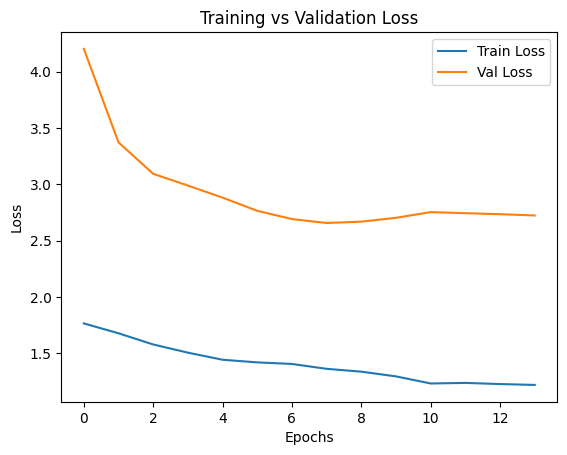

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [17]:
loss, acc, auc = model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

1/1 - 0s - 156ms/step - AUC: 0.4444 - accuracy: 0.2143 - loss: 2.6557
Restored model, accuracy: 21.43%


In [18]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

# Apply threshold to get binary predictions
y_pred = (y_pred_prob >= 0.5).astype(int)

print("CNN:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro", zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average="macro", zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average="macro", zero_division=0))

print(classification_report(y_test, y_pred, target_names=labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
CNN:
Accuracy: 0.07142857142857142
Precision: 0.4259259259259259
Recall: 0.3703703703703704
F1 Score: 0.3666666666666667
              precision    recall  f1-score   support

        mint       0.50      0.33      0.40         6
        leak       0.11      0.33      0.17         3
       limit       0.67      0.44      0.53         9

   micro avg       0.37      0.39      0.38        18
   macro avg       0.43      0.37      0.37        18
weighted avg       0.52      0.39      0.43        18
 samples avg       0.29      0.27      0.26        18



## CNN With Autoencoder

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

X_unlabeled = np.concatenate([X_train, X_test], axis=0)
# Input
input_layer = Input(shape=(opcode_dim,))

# Encoder
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)

# Decoder
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(opcode_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_unlabeled, X_unlabeled, epochs=30, batch_size=64)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 5137.5391
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 5135.8882
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5134.9556
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5134.5308
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 5134.3481
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5134.1191
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5133.7715
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5133.5581
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 5133.3936
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5133.3701
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5133.3535
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 5133.3335
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 5133.3027
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5133.2104
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 

In [20]:
X_encoded = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y_train, test_size=0.2, random_state=42)

In [23]:
def EncodedMLClassifier():
    return Sequential([
        Dense(256, input_dim=128, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(len(labels), activation='sigmoid')
    ])

classifier = EncodedMLClassifier()

classifier.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

model_file = os.path.join(MODEL_PATH, "encoded_cnn_best_model_on_crpwarner_opcode_freq.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(model_file, save_best_only=True)
]

history = classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3056 - loss: 1.1790

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3056 - loss: 1.1790 - val_accuracy: 0.2000 - val_loss: 3.8194 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5278 - loss: 1.0356

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5278 - loss: 1.0356 - val_accuracy: 0.2000 - val_loss: 3.3793 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4444 - loss: 0.9783

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.4444 - loss: 0.9783 - val_accuracy: 0.2000 - val_loss: 3.0798 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5000 - loss: 0.9545

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5000 - loss: 0.9545 - val_accuracy: 0.1000 - val_loss: 2.7936 - learning_rate: 0.0010
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4444 - loss: 0.9004

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4444 - loss: 0.9004 - val_accuracy: 0.1000 - val_loss: 2.5629 - learning_rate: 0.0010
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3056 - loss: 0.8782

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.3056 - loss: 0.8782 - val_accuracy: 0.0000e+00 - val_loss: 2.4045 - learning_rate: 0.0010
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4444 - loss: 0.7875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.4444 - loss: 0.7875 - val_accuracy: 0.0000e+00 - val_loss: 2.2652 - learning_rate: 0.0010
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4444 - loss: 0.8010

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.4444 - loss: 0.8010 - val_accuracy: 0.0000e+00 - val_loss: 2.1925 - learning_rate: 0.0010
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3611 - loss: 0.7664

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3611 - loss: 0.7664 - val_accuracy: 0.0000e+00 - val_loss: 2.1641 - learning_rate: 0.0010
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3889 - loss: 0.7628

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.3889 - loss: 0.7628 - val_accuracy: 0.0000e+00 - val_loss: 2.1394 - learning_rate: 0.0010
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3333 - loss: 0.7245

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.3333 - loss: 0.7245 - val_accuracy: 0.0000e+00 - val_loss: 2.0882 - learning_rate: 0.0010
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4444 - loss: 0.7207

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4444 - loss: 0.7207 - val_accuracy: 0.0000e+00 - val_loss: 2.0184 - learning_rate: 0.0010
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3889 - loss: 0.7265

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.3889 - loss: 0.7265 - val_accuracy: 0.0000e+00 - val_loss: 1.9406 - learning_rate: 0.0010
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3333 - loss: 0.7265

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.3333 - loss: 0.7265 - val_accuracy: 0.0000e+00 - val_loss: 1.8445 - learning_rate: 0.0010
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3333 - loss: 0.6724

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3333 - loss: 0.6724 - val_accuracy: 0.0000e+00 - val_loss: 1.7424 - learning_rate: 0.0010
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2500 - loss: 0.6827

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.2500 - loss: 0.6827 - val_accuracy: 0.0000e+00 - val_loss: 1.6457 - learning_rate: 0.0010
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3611 - loss: 0.7106

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3611 - loss: 0.7106 - val_accuracy: 0.0000e+00 - val_loss: 1.5801 - learning_rate: 0.0010
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3056 - loss: 0.6425

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3056 - loss: 0.6425 - val_accuracy: 0.0000e+00 - val_loss: 1.5152 - learning_rate: 0.0010
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3611 - loss: 0.6793

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.3611 - loss: 0.6793 - val_accuracy: 0.0000e+00 - val_loss: 1.4820 - learning_rate: 0.0010
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2778 - loss: 0.6444

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2778 - loss: 0.6444 - val_accuracy: 0.0000e+00 - val_loss: 1.4559 - learning_rate: 0.0010
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3333 - loss: 0.6078

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3333 - loss: 0.6078 - val_accuracy: 0.0000e+00 - val_loss: 1.4419 - learning_rate: 0.0010
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3611 - loss: 0.6154

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3611 - loss: 0.6154 - val_accuracy: 0.0000e+00 - val_loss: 1.4347 - learning_rate: 0.0010
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3611 - loss: 0.6145 - val_accuracy: 0.0000e+00 - val_loss: 1.4369 - learning_rate: 0.0010
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3333 - loss: 0.5910

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3333 - loss: 0.5910 - val_accuracy: 0.0000e+00 - val_loss: 1.4262 - learning_rate: 0.0010
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3056 - loss: 0.6314

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3056 - loss: 0.6314 - val_accuracy: 0.0000e+00 - val_loss: 1.4197 - learning_rate: 0.0010
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3611 - loss: 0.6129

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.3611 - loss: 0.6129 - val_accuracy: 0.0000e+00 - val_loss: 1.4177 - learning_rate: 0.0010
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3333 - loss: 0.5659

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.3333 - loss: 0.5659 - val_accuracy: 0.0000e+00 - val_loss: 1.4106 - learning_rate: 0.0010
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3333 - loss: 0.6168

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3333 - loss: 0.6168 - val_accuracy: 0.0000e+00 - val_loss: 1.4082 - learning_rate: 0.0010
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3333 - loss: 0.5922 - val_accuracy: 0.0000e+00 - val_loss: 1.4123 - learning_rate: 0.0010
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4167 - loss: 0.5667

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4167 - loss: 0.5667 - val_accuracy: 0.0000e+00 - val_loss: 1.3956 - learning_rate: 0.0010


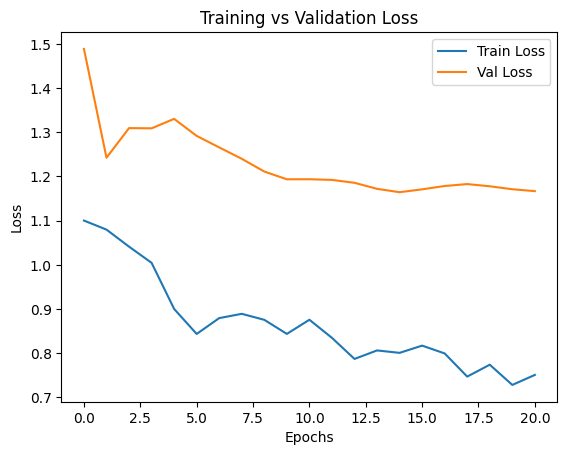

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [28]:
y_pred_prob = classifier.predict(X_val)
y_pred = (y_pred_prob >= 0.05).astype(int)

print(classification_report(y_val, y_pred, target_names=labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
              precision    recall  f1-score   support

        mint       0.33      0.25      0.29         4
        leak       0.22      0.67      0.33         3
       limit       0.10      1.00      0.18         1

   micro avg       0.18      0.50      0.27         8
   macro avg       0.22      0.64      0.27         8
weighted avg       0.26      0.50      0.29         8
 samples avg       0.18      0.30      0.22         8

